In [16]:
import pandas as pd

satisfaction_df = pd.read_csv('./20250807 실습 Data/customer_satisfaction.csv')
transactions_df = pd.read_csv('./20250807 실습 Data/customer_transactions.csv')
marketing_df = pd.read_csv('./20250807 실습 Data/marketing_performance.csv')

print(satisfaction_df.head())
print(transactions_df.head())
print(marketing_df.head())

   customer_id contact_date contact_reason  satisfaction_score  \
0          495   2023-06-16      technical                 4.0   
1          495   2024-03-21       shipping                 1.8   
2          727   2023-07-03        product                 4.3   
3           86   2023-07-04      technical                 4.3   
4          471   2023-08-17      technical                 4.2   

   resolution_time_hours  repeat_contact  
0                   11.4           False  
1                    8.1            True  
2                    4.0           False  
3                    2.0           False  
4                    5.0           False  
   customer_id registration_date acquisition_channel customer_segment  \
0            1        2023-04-13               email          premium   
1            1        2023-04-13               email          premium   
2            1        2023-04-13               email          premium   
3            1        2023-04-13               email 

In [24]:
print(transactions['acquisition_channel'].value_counts())

acquisition_channel
organic         1421
paid_search     1078
social_media     951
email            682
referral         437
Name: count, dtype: int64


문제 1: 채널별 고객 획득 비용(CAC) 및 생애 가치(LTV) 분석
목표: 마케팅 채널의 진정한 ROI를 평가하기 위해 CAC와 LTV를 계산하고 최적 투자 전략을 제안하세요.
1. 데이터 로드 및 전처리
2. 채널별 CAC 계산
    - 2024년 데이터만 사용
    - 각 채널별 총 마케팅 비용 집계
    - 각 채널별 신규 고객 수 집계 (2024년 첫 거래 기준)
    - CAC = 총 마케팅 비용 / 신규 고객 수
    - organic과 referral 채널은 CAC = 0으로 처리
3. 고객별 LTV 계산
4. 채널별 LTV 및 ROI 분석
    - 채널별 평균 LTV 계산
    - ROI = LTV / CAC 계산 (organic, referral은 무한대 처리)
    - payback period = CAC / (월평균 구매금액) 계산
5. 시각화 및 전략 제안 (15분)
    - CAC vs LTV 산점도 차트
    - 채널별 ROI 막대 차트
    - 마케팅 예산 재배분 제안 (현재 vs 최적 배분)

In [ ]:
# 문제1_2
import pandas as pd

# 파일 불러오기
df = pd.read_csv('./20250807 실습 Data/marketing_performance.csv', parse_dates=['month'])

# 2024년 데이터 필터링
df_2024 = df[df['month'].dt.year == 2024]

# 채널별 총 마케팅 비용 및 신규 고객 수 합산
agg = df_2024.groupby('channel').agg({
    'marketing_spend': 'sum',
    'new_customers': 'sum'
}).reset_index()

# CAC 계산
agg['cac'] = agg['marketing_spend'] / agg['new_customers']

# organic, referral 채널은 CAC = 0 처리
agg.loc[agg['channel'].isin(['organic', 'referral']), 'cac'] = 0

# NaN → 0 (신규 고객 없거나 지출이 없는 경우)
agg = agg.fillna(0)

# 결과 출력
print(agg[['channel', 'marketing_spend', 'new_customers', 'cac']])

        channel  marketing_spend  new_customers         cac
0         email     17763.268813            158  112.425752
1       organic         0.000000            302    0.000000
2   paid_search     97849.029394            224  436.826024
3      referral     11867.432377            106    0.000000
4  social_media     59628.676756            182  327.630092


In [ ]:
# 문제1-3 (※ order_value 기준)
import pandas as pd

# 데이터 불러오기
transactions = pd.read_csv('./20250807 실습 Data/customer_transactions.csv')

# 고객별 LTV = 모든 거래의 order_value 합
ltv_df = transactions.groupby('customer_id')['order_value'].sum().reset_index()
ltv_df.rename(columns={'order_value': 'ltv'}, inplace=True)

# 결과 확인
print(ltv_df.head())

   customer_id     ltv
0            1  938.00
1            2  660.75
2            3  548.71
3            4  102.23
4            5  378.85


In [ ]:
# 문제1_4
import pandas as pd
import numpy as np

# 1. 데이터 불러오기
transactions = pd.read_csv('./20250807 실습 Data/customer_transactions.csv', parse_dates=['transaction_date'])
marketing = pd.read_csv('./20250807 실습 Data/marketing_performance.csv', parse_dates=['month'])

# 2. CAC 계산 (2024년)
marketing_2024 = marketing[marketing['month'].dt.year == 2024]
cac_df = marketing_2024.groupby('channel').agg({
    'marketing_spend': 'sum',
    'new_customers': 'sum'
}).reset_index()
cac_df['cac'] = cac_df['marketing_spend'] / cac_df['new_customers']
cac_df.loc[cac_df['channel'].isin(['organic', 'referral']), 'cac'] = 0

# 3. 고객별 LTV (order_value 합) + 채널
customer_ltv = transactions.groupby('customer_id').agg({
    'order_value': 'sum',
    'acquisition_channel': 'first'
}).reset_index()
customer_ltv.rename(columns={'order_value': 'ltv'}, inplace=True)

# 4. 채널별 평균 LTV
channel_ltv = customer_ltv.groupby('acquisition_channel')['ltv'].mean().reset_index()
channel_ltv.rename(columns={'ltv': 'avg_ltv'}, inplace=True)

# 5. ROI 계산 (LTV / CAC)
roi_df = pd.merge(channel_ltv, cac_df[['channel', 'cac']], left_on='acquisition_channel', right_on='channel', how='left')
roi_df['roi'] = roi_df.apply(
    lambda row: np.inf if row['acquisition_channel'] in ['organic', 'referral'] else row['avg_ltv'] / row['cac'],
    axis=1
)

# 6. Payback Period 계산 = CAC / 월평균 구매금액
transactions['year_month'] = transactions['transaction_date'].dt.to_period('M')
active_months = transactions.groupby('customer_id')['year_month'].nunique().reset_index()
active_months.rename(columns={'year_month': 'active_months'}, inplace=True)

monthly_avg = customer_ltv.merge(active_months, on='customer_id')
monthly_avg['monthly_avg_purchase'] = monthly_avg['ltv'] / monthly_avg['active_months']

monthly_by_channel = monthly_avg.groupby('acquisition_channel')['monthly_avg_purchase'].mean().reset_index()

roi_df = pd.merge(roi_df, monthly_by_channel, on='acquisition_channel', how='left')
roi_df['payback_period'] = roi_df.apply(
    lambda row: np.inf if row['acquisition_channel'] in ['organic', 'referral'] else row['cac'] / row['monthly_avg_purchase'],
    axis=1
)

# 7. 결과 출력
result = roi_df[['acquisition_channel', 'avg_ltv', 'cac', 'roi', 'monthly_avg_purchase', 'payback_period']]
print(result)

  acquisition_channel     avg_ltv         cac       roi  monthly_avg_purchase  \
0               email  441.583050  112.425752  3.927775             98.398824   
1             organic  370.455232    0.000000       inf             89.662586   
2         paid_search  402.151966  436.826024  0.920623             91.410016   
3            referral  401.625895    0.000000       inf             95.808747   
4        social_media  404.525024  327.630092  1.234700             93.046472   

   payback_period  
0        1.142552  
1             inf  
2        4.778755  
3             inf  
4        3.521145  


C:\Users\trueb\AppData\Local\Temp\ipykernel_13100\2041345930.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=finite_roi.sort_values('roi', ascending=False),


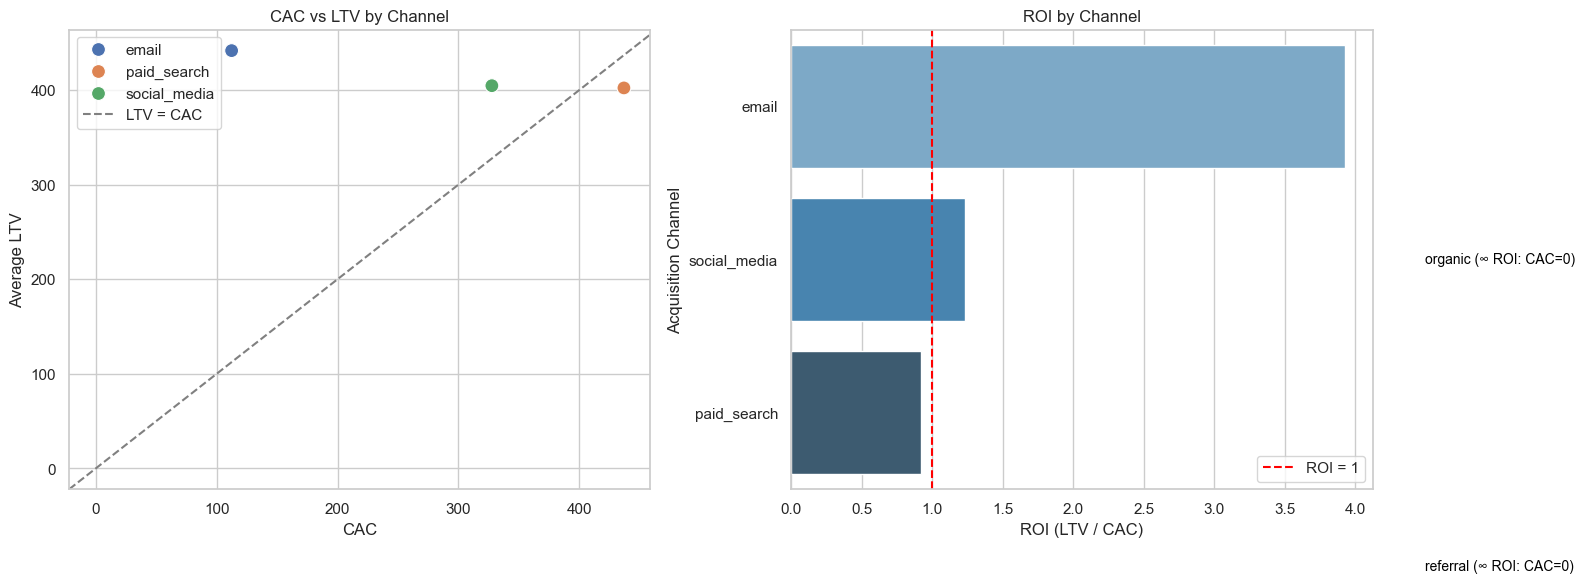


📊 마케팅 예산 재배분 전략 (현재 vs 최적):
        channel  marketing_spend  optimal_spend  spend_diff
0         email         17763.27      120813.39   103050.12
1       organic             0.00            NaN         NaN
2   paid_search         97849.03       28317.19   -69531.84
3      referral         11867.43            NaN         NaN
4  social_media         59628.68       37977.83   -21650.85


In [ ]:
# 문제1_5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기
transactions = pd.read_csv('./20250807 실습 Data/customer_transactions.csv', parse_dates=['transaction_date'])
marketing = pd.read_csv('./20250807 실습 Data/marketing_performance.csv', parse_dates=['month'])

# 2. 채널명 정규화
transactions['acquisition_channel'] = transactions['acquisition_channel'].str.strip().str.lower().str.replace(" ", "_")
marketing['channel'] = marketing['channel'].str.strip().str.lower().str.replace(" ", "_")

# 3. CAC 계산 (2024년 데이터만 사용)
marketing_2024 = marketing[marketing['month'].dt.year == 2024]
cac_df = marketing_2024.groupby('channel').agg({
    'marketing_spend': 'sum',
    'new_customers': 'sum'
}).reset_index()
cac_df['cac'] = cac_df['marketing_spend'] / cac_df['new_customers']
cac_df.loc[cac_df['channel'].isin(['organic', 'referral']), 'cac'] = 0

# 4. 고객별 LTV 계산 (order_value 합산)
customer_ltv = transactions.groupby('customer_id').agg({
    'order_value': 'sum',
    'acquisition_channel': 'first'
}).reset_index()
customer_ltv.rename(columns={'order_value': 'ltv'}, inplace=True)

# 5. 채널별 평균 LTV
channel_ltv = customer_ltv.groupby('acquisition_channel')['ltv'].mean().reset_index()
channel_ltv.rename(columns={'ltv': 'avg_ltv'}, inplace=True)

# 6. ROI 계산
roi_df = pd.merge(channel_ltv, cac_df[['channel', 'cac']], left_on='acquisition_channel', right_on='channel', how='left')
roi_df['roi'] = roi_df.apply(
    lambda row: np.inf if row['acquisition_channel'] in ['organic', 'referral'] else row['avg_ltv'] / row['cac'],
    axis=1
)

# 7. Payback Period 계산
transactions['year_month'] = transactions['transaction_date'].dt.to_period('M')
active_months = transactions.groupby('customer_id')['year_month'].nunique().reset_index()
active_months.rename(columns={'year_month': 'active_months'}, inplace=True)

monthly_avg = customer_ltv.merge(active_months, on='customer_id')
monthly_avg['monthly_avg_purchase'] = monthly_avg['ltv'] / monthly_avg['active_months']

monthly_by_channel = monthly_avg.groupby('acquisition_channel')['monthly_avg_purchase'].mean().reset_index()
roi_df = pd.merge(roi_df, monthly_by_channel, on='acquisition_channel', how='left')
roi_df['payback_period'] = roi_df.apply(
    lambda row: np.inf if row['acquisition_channel'] in ['organic', 'referral'] else row['cac'] / row['monthly_avg_purchase'],
    axis=1
)

# 8. ROI 요약 정리
result = roi_df[['acquisition_channel', 'avg_ltv', 'cac', 'roi', 'monthly_avg_purchase', 'payback_period']]

# 9. 시각화 (1행 2열)
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 9-1. 왼쪽: CAC vs LTV 산점도
scatter_data = result[result['cac'] > 0]
sns.scatterplot(data=scatter_data, x='cac', y='avg_ltv', hue='acquisition_channel', s=100, ax=axes[0])
axes[0].set_title('CAC vs LTV by Channel')
axes[0].set_xlabel('CAC')
axes[0].set_ylabel('Average LTV')
axes[0].axline((0, 0), slope=1, linestyle='--', color='gray', label='LTV = CAC')
axes[0].legend()

# 9-2. 오른쪽: ROI 막대 (∞은 텍스트로)
finite_roi = result[result['roi'] < np.inf].copy()
infinite_roi = result[result['roi'] == np.inf].copy()

sns.barplot(data=finite_roi.sort_values('roi', ascending=False),
            x='roi', y='acquisition_channel', palette='Blues_d', ax=axes[1])
axes[1].set_title('ROI by Channel')
axes[1].set_xlabel('ROI (LTV / CAC)')
axes[1].set_ylabel('Acquisition Channel')
axes[1].axvline(1.0, color='red', linestyle='--', label='ROI = 1')

# ∞ ROI 채널 주석 표시
for i, row in infinite_roi.iterrows():
    axes[1].text(4.5, i, f"{row['acquisition_channel']} (∞ ROI: CAC=0)", color='black', fontsize=10, va='center')

axes[1].legend()
plt.tight_layout()
plt.show()

# 10. 마케팅 예산 재배분 제안
current_spend = marketing_2024.groupby('channel')['marketing_spend'].sum().reset_index()
total_spend = current_spend['marketing_spend'].sum()

roi_weights = result[result['roi'] < np.inf].copy()
roi_weights['roi_weight'] = roi_weights['roi'] / roi_weights['roi'].sum()
roi_weights = roi_weights[['acquisition_channel', 'roi_weight']]

budget_compare = pd.merge(current_spend, roi_weights, left_on='channel', right_on='acquisition_channel', how='left')
budget_compare['optimal_spend'] = budget_compare['roi_weight'] * total_spend
budget_compare['spend_diff'] = budget_compare['optimal_spend'] - budget_compare['marketing_spend']

# 11. 출력
print("\n📊 마케팅 예산 재배분 전략 (현재 vs 최적):")
print(budget_compare[['channel', 'marketing_spend', 'optimal_spend', 'spend_diff']].round(2))

마케팅 예산 재배분 제안
1. Email 마케팅 확대 필요
ROI가 높아 투자 대비 효과 큼
현재 지출(17K) → 최적 지출(120K)로 약 7배 확대 권장
전환율 높거나 고객 LTV가 큼을 의미함

2. Paid Search & Social Media 지출 감축
paid_search: 고객 획득은 많지만 CAC가 너무 높아 ROI 낮음
social_media: ROI가 1을 약간 넘음 → 일부 유지 가능, 다만 효율은 낮음

3. Organic / Referral은 무료 채널
비용이 0이므로 ROI는 무한대
투자보다는 SEO, UX 개선, 고객 추천 유도 전략 강화에 집중

문제 2: 고객 코호트 분석 및 유지율 개선 전략
목표: "월별 가입 코호트"의 유지율과 매출 기여도를 분석하여 고객 유지 전략을 수립하세요.
1. 코호트 그룹 생성
2. 월별 유지율 계산
    - 각 거래의 코호트 대비 경과 개월 수 계산
    - 코호트별 Month 0, 1, 2, ... 12에서의 활성 고객 수
    - 유지율 테이블 생성 (코호트 × 경과월)
    - 평균 유지율 곡선 계산
3. 코호트별 매출 기여도 분석
    - 각 코호트의 월별 누적 매출 계산
    - 코호트별 고객 1인당 누적 매출 (ARPU) 계산
    - 6개월 후, 12개월 후 예상 LTV 추정
4. 유지율 히트맵 시각화
5. 개선 전략 수립
    - 유지율이 급격히 감소하는 시점 식별
    - 고성과 코호트 vs 저성과 코호트 특성 비교
    - 유지율 개선을 위한 액션 아이템 3가지 제안

In [30]:
# 문제2_1
# 1. 거래 날짜 형식 변환
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

# 2. 고객별 최초 구매 날짜 계산 → "cohort_month" 생성
transactions['cohort_month'] = (
    transactions.groupby('customer_id')['transaction_date']
    .transform('min')  # 고객별 최초 구매일
    .dt.to_period('M')  # 월 단위로 변환 (예: 2024-01)
)

# 3. 실제 구매가 발생한 달 → "order_month"
transactions['order_month'] = transactions['transaction_date'].dt.to_period('M')

# 4. 코호트 인덱스 = 몇 개월이 지났는지 (0: 첫 달, 1: 다음 달...)
transactions['cohort_index'] = (
    transactions['order_month'] - transactions['cohort_month']
).apply(lambda x: x.n)

📊 월별 유지율 테이블:
cohort_index   0       1       2       3       4       5       6       7   \
cohort_month                                                                
2023-01       1.0  0.4167  0.3333  0.1667  0.2500  0.3333  0.1667  0.2500   
2023-02       1.0  0.2500  0.2500  0.3542  0.2083  0.3333  0.3542  0.2708   
2023-03       1.0  0.1628  0.2558  0.2558  0.2326  0.2791  0.2558  0.2558   
2023-04       1.0  0.3000  0.2333  0.2333  0.3167  0.2833  0.2833  0.3167   
2023-05       1.0  0.3971  0.3382  0.3088  0.3088  0.3824  0.3088  0.2794   
2023-06       1.0  0.3810  0.2222  0.3492  0.2857  0.2857  0.3016  0.2698   
2023-07       1.0  0.2639  0.2083  0.1944  0.1944  0.2222  0.4306  0.2500   
2023-08       1.0  0.3521  0.3380  0.2394  0.2113  0.2254  0.2958  0.2676   
2023-09       1.0  0.2625  0.3375  0.1625  0.2375  0.2875  0.2500  0.3125   
2023-10       1.0  0.2568  0.3649  0.2838  0.2973  0.2838  0.3784  0.2162   
2023-11       1.0  0.2755  0.3265  0.3163  0.3878  0.3367  0.3

c:\Users\trueb\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


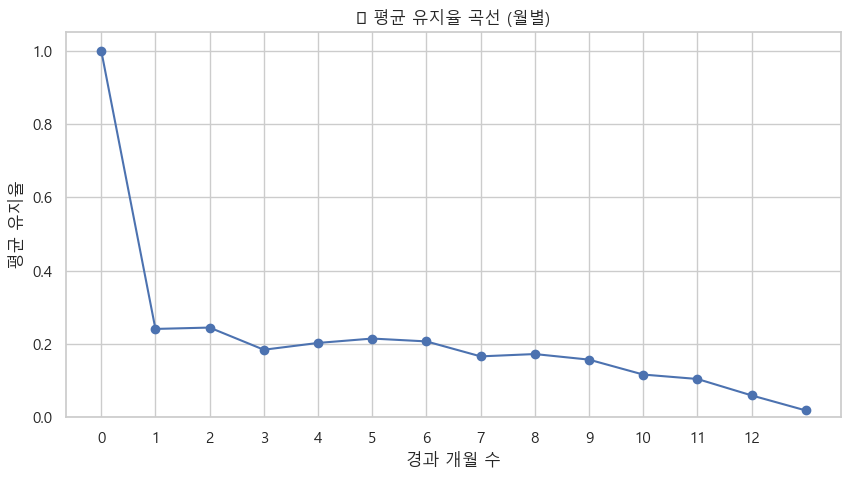

In [ ]:
# 문제2_2
import pandas as pd
import matplotlib.pyplot as plt

# 1. 날짜 변환 및 코호트 컬럼 생성
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
transactions['cohort_month'] = transactions.groupby('customer_id')['transaction_date'].transform('min').dt.to_period('M')
transactions['order_month'] = transactions['transaction_date'].dt.to_period('M')

# 2. 경과 개월 수 계산
transactions['cohort_index'] = (transactions['order_month'] - transactions['cohort_month']).apply(lambda x: x.n)

# 3. 고객별 월 방문 고유값 추출 (중복 구매 제거 목적)
cohort_data = transactions[['customer_id', 'cohort_month', 'order_month', 'cohort_index']].drop_duplicates()

# 4. 각 코호트에서 각 경과월의 활성 고객 수 집계
cohort_counts = cohort_data.groupby(['cohort_month', 'cohort_index'])['customer_id'].nunique().unstack(fill_value=0)

# 5. 유지율 테이블 생성
cohort_sizes = cohort_counts.iloc[:, 0]  # 각 코호트의 기준 고객 수 (Month 0)
retention = cohort_counts.divide(cohort_sizes, axis=0).round(4)

# 6. 유지율 테이블 출력
print("📊 월별 유지율 테이블:")
print(retention)

# 7. 평균 유지율 계산 (cohort_index 기준)
avg_retention = retention.mean(axis=0)
print("\n📈 평균 유지율 곡선:")
print(avg_retention)

# 8. 평균 유지율 시각화
plt.figure(figsize=(10, 5))
avg_retention.plot(marker='o')
plt.title('📊 평균 유지율 곡선 (월별)')
plt.xlabel('경과 개월 수')
plt.ylabel('평균 유지율')
plt.grid(True)
plt.xticks(range(0, 13))
plt.ylim(0, 1.05)
plt.show()

In [34]:
# 한글폰트 이그러짐 방지
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 1. 운영체제에 맞는 한글 폰트 지정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'    # macOS용
else:
    plt.rcParams['font.family'] = 'NanumGothic'     # Linux 등 (폰트 설치 필요)

# 2. 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 문제2_3
import pandas as pd
import matplotlib.pyplot as plt

# 1. 날짜 정리 및 코호트 설정
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
transactions['cohort_month'] = transactions.groupby('customer_id')['transaction_date'].transform('min').dt.to_period('M')
transactions['order_month'] = transactions['transaction_date'].dt.to_period('M')
transactions['cohort_index'] = (transactions['order_month'] - transactions['cohort_month']).apply(lambda x: x.n)

# 2. 코호트별 월별 매출 합산
revenue_by_cohort = transactions.groupby(['cohort_month', 'cohort_index'])['order_value'].sum().unstack(fill_value=0)

# 3. 코호트별 누적 매출
cumulative_revenue = revenue_by_cohort.cumsum(axis=1)

# 4. 코호트별 고객 수 (Month 0 기준)
cohort_sizes = transactions.groupby('cohort_month')['customer_id'].nunique()

# 5. ARPU = 누적 매출 ÷ 기준 고객 수
arpu = cumulative_revenue.divide(cohort_sizes, axis=0).round(2)

# 6. 6개월/12개월 후 예상 LTV (ARPU 기반 추정)
ltv_6m = arpu[6] if 6 in arpu.columns else None
ltv_12m = arpu[12] if 12 in arpu.columns else None

# 결과 출력
print("💰 코호트별 고객 1인당 누적 매출 (ARPU):")
print(arpu)

if ltv_6m is not None:
    print("\n📊 6개월 후 예상 LTV:")
    print(ltv_6m.sort_index())
else:
    print("\n⚠️ 6개월차 데이터가 충분하지 않습니다.")

if ltv_12m is not None:
    print("\n📊 12개월 후 예상 LTV:")
    print(ltv_12m.sort_index())
else:
    print("\n⚠️ 12개월차 데이터가 충분하지 않습니다.")
    

💰 코호트별 고객 1인당 누적 매출 (ARPU):
cohort_index      0       1       2       3       4       5       6       7   \
cohort_month                                                                   
2023-01        71.27  112.70  149.31  167.30  194.18  226.55  236.92  259.15   
2023-02       100.31  127.47  152.55  188.68  211.68  240.91  275.51  309.99   
2023-03        85.34  102.78  130.10  154.99  170.88  192.48  219.99  249.83   
2023-04        97.48  129.03  153.56  176.42  206.48  235.40  264.46  299.26   
2023-05        96.37  134.47  175.42  203.74  231.87  268.11  300.69  330.30   
2023-06       102.01  142.92  164.10  202.71  234.47  260.99  298.90  326.85   
2023-07        89.35  117.61  147.74  171.52  200.98  222.46  277.92  305.61   
2023-08        88.92  129.77  156.65  187.15  208.69  230.71  254.97  285.96   
2023-09        84.37  112.18  152.46  168.01  190.90  219.65  244.02  276.22   
2023-10        95.00  123.37  157.78  184.92  215.75  247.35  292.25  317.62   
2023-11     

c:\Users\trueb\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


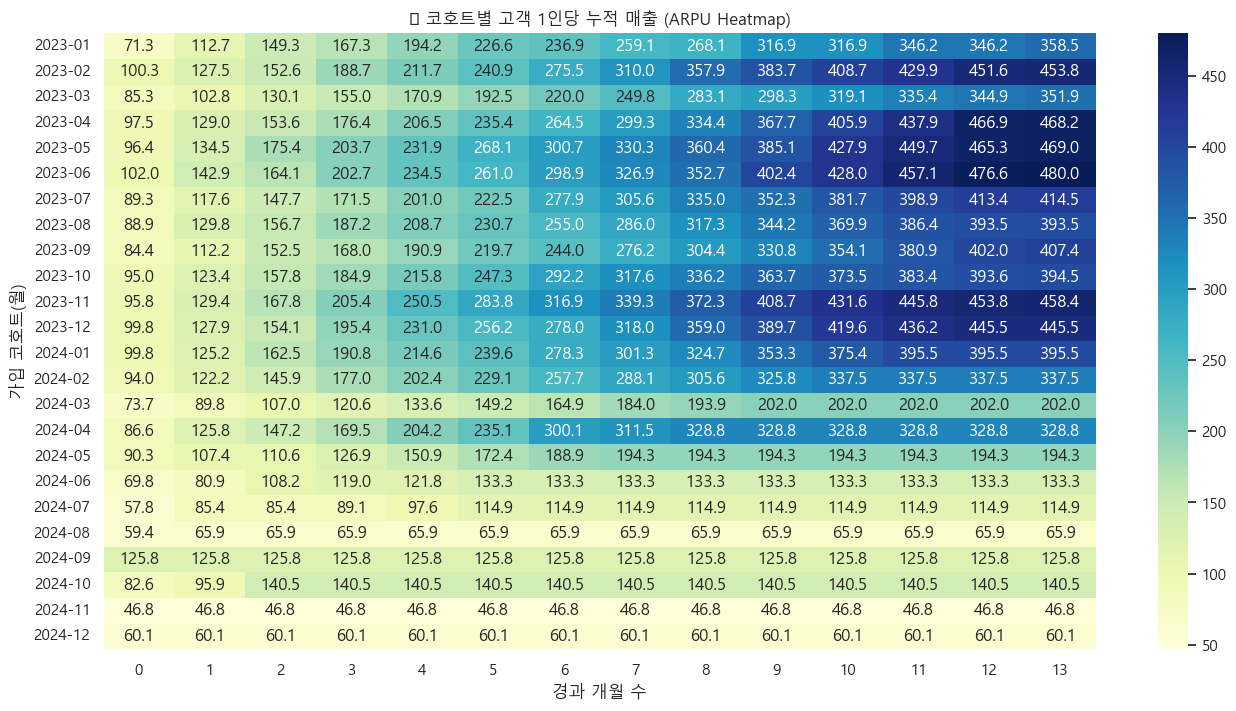

In [43]:
import seaborn as sns
plt.figure(figsize=(16, 8))
sns.heatmap(arpu, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title('💰 코호트별 고객 1인당 누적 매출 (ARPU Heatmap)')
plt.xlabel('경과 개월 수')
plt.ylabel('가입 코호트(월)')
plt.show()

c:\Users\trueb\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


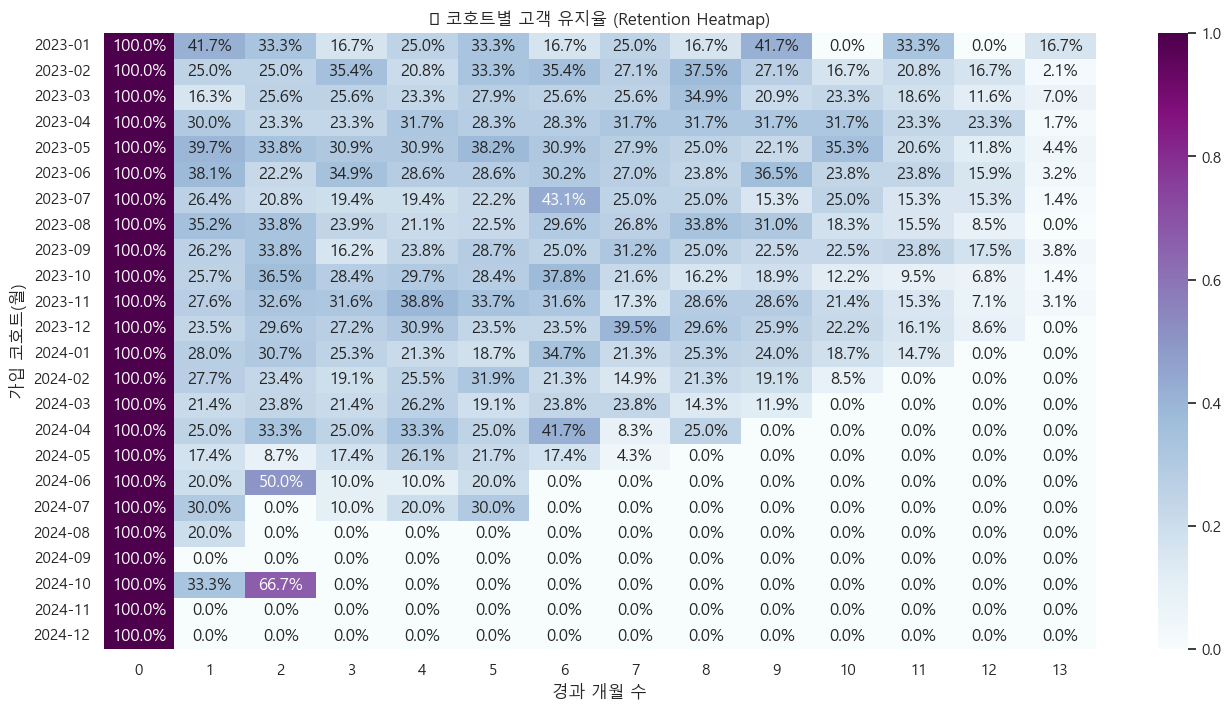

In [ ]:
# 문제2_4
plt.figure(figsize=(16, 8))
sns.heatmap(retention, annot=True, fmt='.1%', cmap='BuPu')
plt.title('📈 코호트별 고객 유지율 (Retention Heatmap)')
plt.xlabel('경과 개월 수')
plt.ylabel('가입 코호트(월)')
plt.show()

📉 평균 유지율 (경과 개월별):
cohort_index
0     1.000
1     0.241
2     0.245
3     0.184
4     0.203
5     0.215
6     0.207
7     0.166
8     0.172
9     0.157
10    0.116
11    0.104
12    0.060
13    0.019
dtype: float64


c:\Users\trueb\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


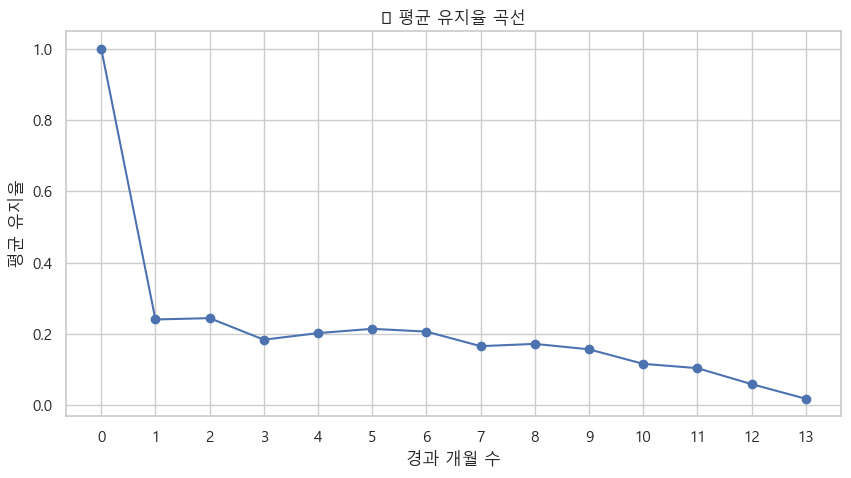

🔥 고성과 코호트 (6개월 ARPU 기준):
cohort_month
2023-11    316.92
2023-05    300.69
2024-04    300.15
Freq: M, Name: 6, dtype: float64

❄️ 저성과 코호트 (6개월 ARPU 기준):
cohort_month
2024-11    46.77
2024-12    60.14
2024-08    65.90
Freq: M, Name: 6, dtype: float64


In [46]:
# 문제2-5
avg_retention = retention.mean(axis=0)

# 평균 유지율 출력
print("📉 평균 유지율 (경과 개월별):")
print(avg_retention.round(3))

# 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
avg_retention.plot(marker='o')
plt.title('📉 평균 유지율 곡선')
plt.xlabel('경과 개월 수')
plt.ylabel('평균 유지율')
plt.xticks(range(0, len(avg_retention)))
plt.grid(True)
plt.show()


# 예: 6개월차 기준으로 ARPU 상위/하위 3개 코호트 비교
top_cohorts = arpu[6].sort_values(ascending=False).head(3)
bottom_cohorts = arpu[6].sort_values(ascending=True).head(3)

print("🔥 고성과 코호트 (6개월 ARPU 기준):")
print(top_cohorts)

print("\n❄️ 저성과 코호트 (6개월 ARPU 기준):")
print(bottom_cohorts)

세가지 액션 아이템
1. 0~1개월 이탈 방지를 위한 온보딩 및 리텐션 프로그램 개발 운영 (앱 푸시 + 할일 쿠폰 + 초기 가입자를 위한 관심 유지용 마케팅 등)
2. 고성과 코호트 확인 후 해당 기간 전략 리뷰 및 재 시행 또는 업그레이드 마케팅 시행
3. 장기 유저를 위한 리텐션 프로그램 개발 
외